In [1]:
import numpy as np
from skimage.filters import threshold_otsu, threshold_local
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
from skimage.color import rgb2grey
from skimage.filters import try_all_threshold
from skimage import filters, segmentation
from skimage.filters import gaussian
from skimage.morphology import dilation, square
from skimage.measure import find_contours
from skimage import exposure

In [2]:
def rgb_to_grey(img):
    return img[:, :, 0:3].sum(axis=-1) / 3.0

def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 0)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value
    return vector

def tlbr(contour):
    return int(contour[:, 0].min()), int(contour[:, 1].min()), int(contour[:, 0].max()), int(contour[:, 1].max())

def bounding_box(contour):
    top = contour[:, 0].min()
    bottom = contour[:, 0].max()
    left = contour[:, 1].min()
    right = contour[:, 1].max()
    bounding_box = np.array([[top, left], [top, right], [bottom, right], [bottom, left], [top, left]], dtype=np.float64)
    return bounding_box

def contour_area(contour):
    t,l,b,r = tlbr(contour)
    return (b - t) * (r - l)

def cut_text_height(im, margin=10):
    hist = im.sum(axis=1)
    hist_idxs = np.nonzero(hist)[0]
    left, right = hist_idxs[0], hist_idxs[-1]
    x1 = left-margin if left-margin >= 0 else 0
    x2 = right+margin if right+margin < hist.size else hist.size
    return {'t': x1, 'b': x2}

def cut_text_width(im,  margin=10):
    hist = im.sum(axis=0)
    hist_idxs = np.nonzero(hist)[0]
    left, right = hist_idxs[0], hist_idxs[-1]
    x1 = left-margin if left-margin >= 0 else 0
    x2 = right+margin if right+margin < hist.size else hist.size
    return {'l': x1, 'r': x2}

def crop_text(im, margin=10):
    coords = {}
    coords.update(cut_text_height(im, margin=margin))
    coords.update(cut_text_width(im, margin=margin))
    return coords

def try_split_rows(_im):
    hst = _im.sum(axis=1)
    ixs = np.nonzero(hst)[0]
    diff = np.diff(ixs)
    nz_args = np.argwhere(diff > 1).ravel()
    start = 0
    splitted = []
    for nz_arg in nz_args:
        splitted.append(_im[start:ixs[nz_arg] + diff[nz_arg] // 2])
        start = ixs[nz_arg] + diff[nz_arg] // 2
    splitted.append(_im[start:])
    return splitted

def try_split_rows_on_coords(_im):
    hst = _im.sum(axis=1)
    ixs = np.nonzero(hst)[0]
    diff = np.diff(ixs)
    nz_args = np.argwhere(diff > 1).ravel()
    start = 0
    splitted = []
    for nz_arg in nz_args:
        splitted.append({'t': start, 'b': ixs[nz_arg] + diff[nz_arg] // 2})
        start = ixs[nz_arg] + diff[nz_arg] // 2
    splitted.append({'t': start, 'b': _im.shape[0]})
    return splitted


def text_segmentation(img, pad_size=50, kernel_shape=(10, 50), min_area=500, margin=10, min_text_height=6, **kwargs):
    if len(img.shape) > 2:
        im_gr = rgb_to_grey(img) / 255.
    elif img.max() > 1:
        im_gr = img / 255.
    else:
        im_gr = img

    global_thresh = threshold_otsu(im_gr)
    binary_global = im_gr < global_thresh
    im_th = binary_global.astype(np.float64)

    im_th_pdt = np.pad(im_th, pad_size, pad_with)
    kernel = np.ones(kernel_shape, np.uint8)
    im_dlt = dilation(im_th, kernel)

    im_pdt = np.pad(im_dlt, pad_size, pad_with)
    contours = find_contours(im_pdt, 0)
    contours = [contour for contour in contours if contour_area(contour) > min_area]

    coords = []
    for contour in contours:
        try:
            t, l, b, r = tlbr(contour)
            crds = crop_text(im_th_pdt[t:b, l:r], margin=margin)
            crds['t'] += t
            crds['l'] += l
            crds['b'] += t
            crds['r'] += l
            coords.append(crds)
        except IndexError:
            pass

    split_coords = []
    for coord in coords:
        imt = im_th_pdt[coord['t']:coord['b'], coord['l']:coord['r']]
        splts = try_split_rows_on_coords(imt)
        for splt in splts:
            split_coords.append(
                {'t': coord['t'] + splt['t'], 'l': coord['l'], 'b': coord['t'] + splt['b'], 'r': coord['r']})

    cut_split_coords = []
    for coord in split_coords:
        crds = crop_text(im_th_pdt[coord['t']:coord['b'], coord['l']:coord['r']])
        crds['t'] += coord['t']
        crds['l'] += coord['l']
        crds['b'] += coord['t']
        crds['r'] += coord['l']
        cut_split_coords.append(crds)

    clear_split_coords = []
    for spltc in cut_split_coords:
        text_crop = crop_text(im_th_pdt[spltc['t']:spltc['b'], spltc['l']:spltc['r']], margin=0)
        if text_crop['b'] - text_crop['t'] > min_text_height:
            clear_split_coords.append(spltc)

    original_coords = []
    for coord in clear_split_coords:
        original_coords.append(
            {
                't': coord['t'] - pad_size,
                'l': coord['l'] - pad_size,
                'b': coord['b'] - pad_size,
                'r': coord['r'] - pad_size
            })

    return original_coords



In [3]:
from collections import Counter
inv_image = np.vectorize(lambda x: 1 - x)


def to_light_background(img):
    mode = Counter(img.ravel().tolist()).most_common(1)[0][0]
    if mode < 0.5:
        return inv_image(img)
    return img

/home/mshpakovych/Work/Orange2/orange_env/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


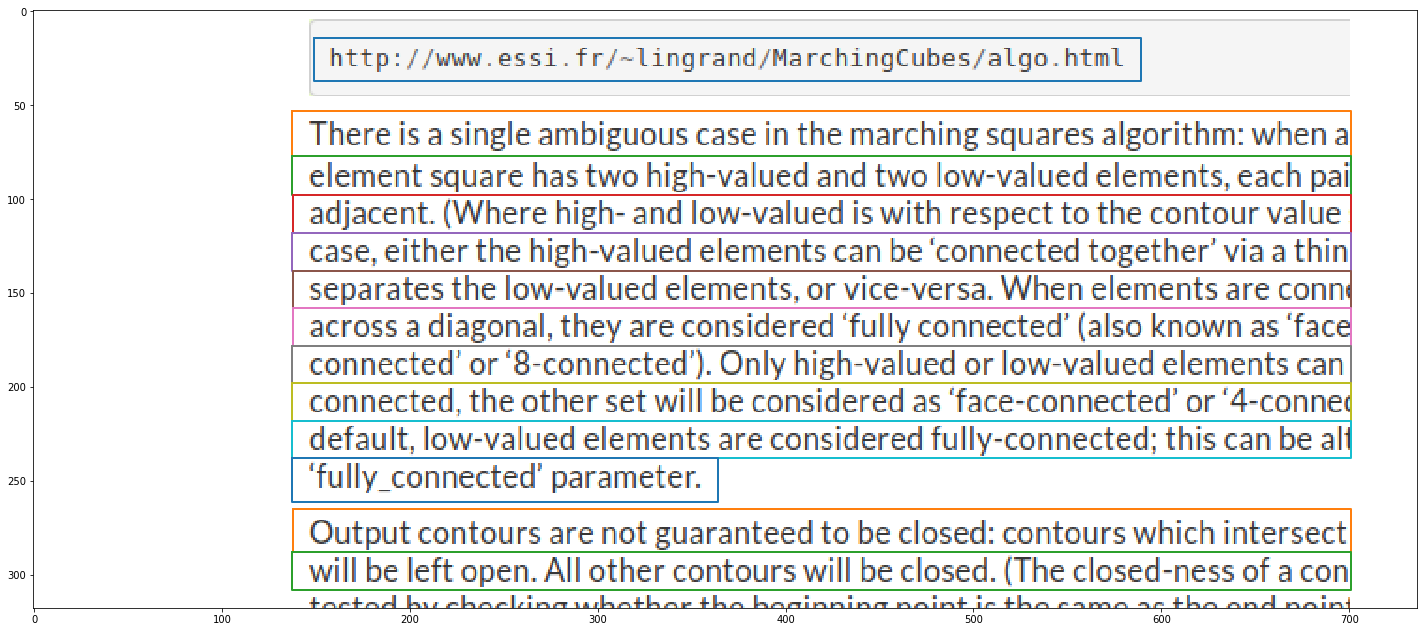

In [24]:
im = imread('/home/mshpakovych/scr2.png')
img = rgb_to_grey(im) / 255.
img = to_light_background(img)

p2, p98 = np.percentile(img, (0.25, 99.75))
img = exposure.rescale_intensity(img, in_range=(p2, p98))

coords = text_segmentation(img, margin=10)

plt.figure(figsize=(20,10))
imshow(im)
for coord in coords:
    top, left, bottom, right = coord['t'], coord['l'], coord['b'], coord['r']
    bbox = np.array([[top, left], [top, right], [bottom, right], [bottom, left], [top, left]], dtype=np.float64)
    plt.plot(bbox[:, 1], bbox[:, 0], linewidth=2)
plt.show()